In [ ]:
import numpy as np
import pandas as pd
import zipfile
import gc
import seaborn as sns
import matplotlib.pyplot as plt
gc.enable()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/Data_btp2/"
train=zipfile.ZipFile(path+"data_train"+".zip","r")
test=zipfile.ZipFile(path+"data_test"+".zip","r")

In [ ]:
data_train = pd.read_csv(train.open('data_train.csv'))
data_test = pd.read_csv(test.open('data_test.csv'))

In [ ]:
X = data_train.drop(['reordered', 'uxp_ratio_last_five'], axis=1)
y = data_train.reordered

In [ ]:
pip install scikit-plot

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.classifiers import plot_feature_importances
from sklearn import metrics
from tqdm import tqdm

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [ ]:
pip install catboost

     |████████████████████████████████| 65.8MB 107kB/s 


In [ ]:
from catboost import CatBoostClassifier
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [ ]:
#For learning Rate and iterations
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1.0]
iterations = [100 , 300 , 600 , 1000]
prec_recall_area = []
dict_of_values = {}

#Loop for the Tuning
for lr in learning_rate:
    for ite in iterations:
        clf = CatBoostClassifier(
        iterations = ite,
        learning_rate=lr,
        verbose=False,
        )

        clf.fit(X_train, list(map(int , y_train)))

        y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
        prec_recall_area.append(np.trapz(recall,precision))
        print("With lr:",lr,",with iter:",ite , ",area is:" ,np.trapz(recall,precision))


In [ ]:
#for bagging temperature
temperature = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#Loop for the tuning
for temp in temperature:
    clf = CatBoostClassifier(
        iterations = 500, 
        depth = 14, #From above and did some iterations
        learning_rate=0.01,
        bagging_temperature = temp,
        verbose = False)

    clf.fit(X_train, list(map(int , y_train)))

    y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    prec_recall_area.append(np.trapz(recall,precision))
    print("With temp:",temp , ",area is:" ,np.trapz(recall,precision))

In [ ]:
#Taking the best one.
#lr = 0.01,iter : 500 , depth: 14 , bagging_temperature : 0.1
clf = CatBoostClassifier(
    iterations = 1000, 
    random_strength = 0.5,
    depth = 14,
    learning_rate=0.01,
    bagging_temperature = 0.1,
    verbose = 3
)

#Mapping y into int format---- [0.0 , 1.0]---> [0,1] (Essential for catboost classifier)
clf.fit(X_train, list(map(int , y_train)))


0:	learn: 0.6806391	total: 6.24s	remaining: 1h 43m 57s
3:	learn: 0.6452749	total: 27.1s	remaining: 1h 52m 39s
6:	learn: 0.6128517	total: 46.8s	remaining: 1h 50m 41s
9:	learn: 0.5833187	total: 1m 7s	remaining: 1h 51m 18s
12:	learn: 0.5559786	total: 1m 28s	remaining: 1h 51m 35s
15:	learn: 0.5311387	total: 1m 49s	remaining: 1h 52m 3s
18:	learn: 0.5083476	total: 2m 9s	remaining: 1h 51m 37s
21:	learn: 0.4874776	total: 2m 31s	remaining: 1h 52m 34s
24:	learn: 0.4689642	total: 2m 47s	remaining: 1h 49m 8s
27:	learn: 0.4517461	total: 3m 10s	remaining: 1h 50m 5s
30:	learn: 0.4358349	total: 3m 31s	remaining: 1h 49m 59s
33:	learn: 0.4212567	total: 3m 51s	remaining: 1h 49m 40s
36:	learn: 0.4080380	total: 4m 12s	remaining: 1h 49m 23s
39:	learn: 0.3958228	total: 4m 32s	remaining: 1h 49m 8s
42:	learn: 0.3846366	total: 4m 53s	remaining: 1h 49m 2s
45:	learn: 0.3743235	total: 5m 14s	remaining: 1h 48m 49s
48:	learn: 0.3649292	total: 5m 35s	remaining: 1h 48m 24s
51:	learn: 0.3562609	total: 5m 55s	remaining:

In [ ]:
thresholds = clf.predict_proba(X_test)[:, 1]
f1_scores = []
values = np.arange(np.mean(thresholds)-(2*np.std(thresholds)) , np.mean(thresholds) +(2*np.std(thresholds))  , 0.02)
for value in tqdm(values):
    y_pred = (clf.predict_proba(X_test)[:, 1] >= value).astype('int')
    f1_scores.append(metrics.f1_score(y_test , y_pred))

100%|██████████| 27/27 [11:17<00:00, 25.10s/it]


NameError: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


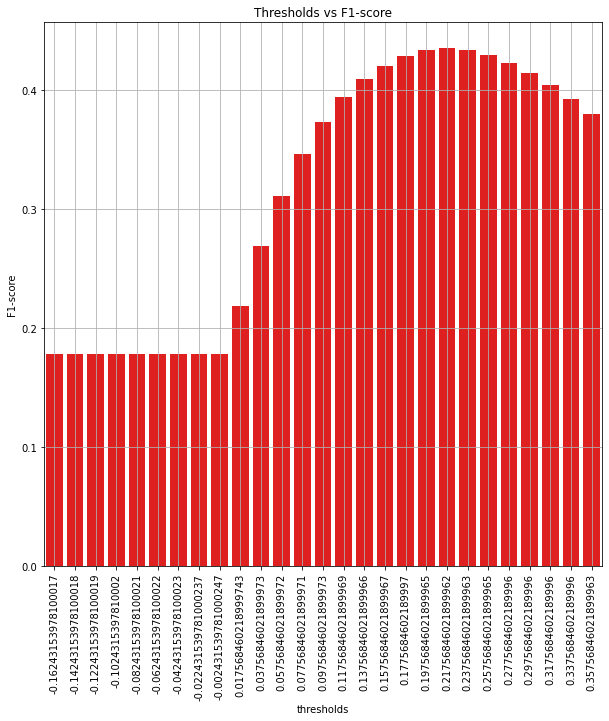

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(values , f1_scores , color = "red")
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")
plt.grid(True)
plt.xticks(rotation = 90)

plt.show()

Confusion Matrix for Test-


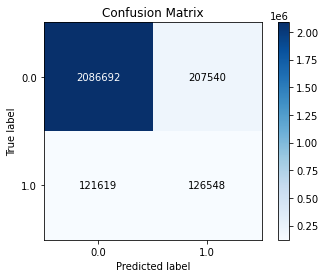

In [28]:
y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
#y_pred
print("Confusion Matrix for Test-")
plot_confusion_matrix(y_test,y_pred)

In [29]:
y_train_pred =(clf.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
print("Training F1 Score:", metrics.f1_score(y_train , y_train_pred))
print("Test F1 Score:",metrics.f1_score(y_test , y_pred))

Training F1 Score: 0.45002683147844025
Test F1 Score: 0.434682398605422


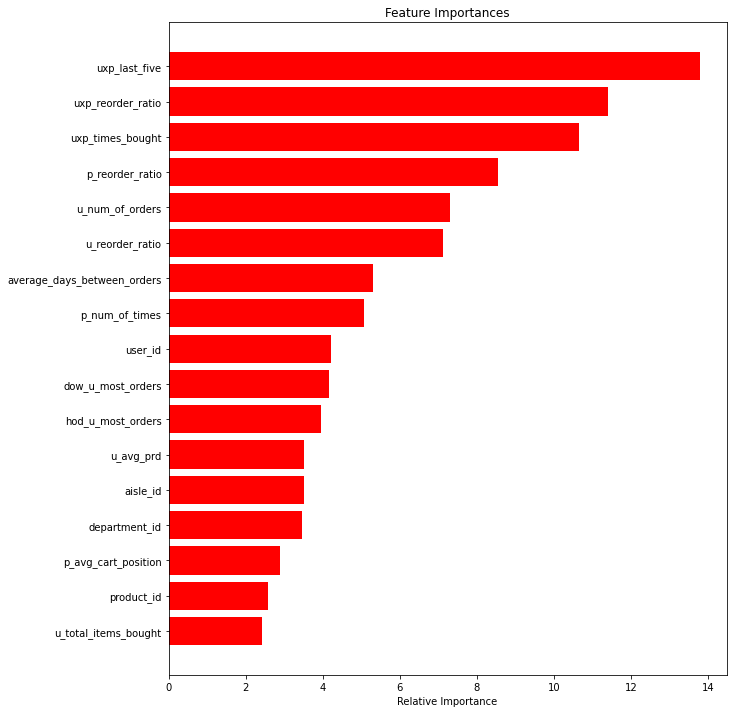

In [30]:
features = X_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()